In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
from cycler import cycler
%matplotlib inline

from scipy import stats

import bayesianchangepoint as bcp
from scipy.stats import beta

TODO: copier et simplifier ce notebook
TODO: pour le match, trouver quelque chose de mieux que le R2?
TODO: voir si le match pour chaque sujet varie en fonction dde h / mode
TODO: autodétruire cette cellule

In [2]:
t_titre = 35/2 #35
t_label = 25/2 #25
fig_width = 15/2 #15
#'black', 'dimgrey', 'dimgray', 'grey', 'gray', 'darkgrey', 'darkgray', ## 'silver', 'lightgrey', 'lightgray'
#'rosybrown','lightcoral', 'indianred', 'firebrick', 'brown', 'darkred', 'red'
colors = ['black','dimgrey','grey','darkgrey','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN'] :
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [5]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN'] :
        a = 'parametre/%s_param_Fit.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [6]:
print(len(colors)==len(param)==len(exp))

True


In [7]:
p_hat_bcp = [[],[],[],[],[],[],[],[],[],[],[]]
p_low_bcp = [[],[],[],[],[],[],[],[],[],[],[]]
p_sup_bcp = [[],[],[],[],[],[],[],[],[],[],[]]

for x in range(len(exp)):
        
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau
    
    p_hat_block = [[],[],[]]
    p_low_block = [[],[],[]]
    p_sup_block = [[],[],[]]
    
    #print('\n', exp[x]['observer'])
    
    for block in range(N_blocks):
        #----------------------------------------------------
        p_bar, r, beliefs = bcp.inference(p[:, block, 0], h=h, p0=.5)

        p_hat, r_hat = bcp.readout(p_bar, r, beliefs)
        
        
        p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
        
        for trial in range(N_trials):
            p_low[trial], p_sup[trial] = beta.ppf([.05, .95], a=p_hat[trial]*r_hat[trial], b=(1-p_hat[trial])*r_hat[trial])
        
        # recupere
        p_hat_block[block] = p_hat
        p_sup_block[block] = p_sup
        p_low_block[block] = p_low
        #----------------------------------------------------
        #print(block, '=', np.corrcoef(results[:, block], p_hat)[0][1])
        #----------------------------------------------------
    p_hat_bcp[x] = p_hat_block
    p_low_bcp[x] = p_low_block
    p_sup_bcp[x] = p_sup_block

### - les premier essais après le switch

In [8]:
# liste de tout
full_proba = [[],[]]
full_bino = [[],[]]
full_results = [[],[]]
full_va = [[],[]]
full_mean = [[],[]]
full_p_hat = [[],[]]
full_p_low = [[],[]]
full_p_sup = [[],[]]


# listes de tout par sujet
proba_sujet = [[],[]]
bino_sujet = [[],[]]
results_sujet = [[],[]]
va_sujet = [[],[]]
mean_sujet = [[],[]]
p_hat_sujet = [[],[]]
p_low_sujet = [[],[]]
p_sup_sujet = [[],[]]

for x in range(len(exp)):

    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    
    p = exp[x]['p']
    results = (exp[x]['results']+1)/2
    v_anti = param[x]['v_anti']
    mean = param[x]['moyenne']
    p_hat = p_hat_bcp[x]
    p_low = p_low_bcp[x]
    p_sup = p_sup_bcp[x]
    
    liste_proba = [[],[]]
    liste_bino = [[],[]]
    liste_results = [[],[]]
    liste_va = [[],[]]
    liste_mean = [[],[]]
    liste_p_hat = [[],[]]
    liste_p_low = [[],[]]
    liste_p_sup = [[],[]]
    
    
    badabada = [0, 3]
    
    for block in range(N_blocks):
        
        switch = []
        for s in range(N_trials):
            if s in [0,50,100,150] :
                switch.append(s)
            if p[s, block, 2]==1 :
                switch.append(s)
        switch.append(N_trials)
        
        for s1 in range(len(switch)-1) :
            
            for a in range(len(badabada)) :

                for trial in np.arange(switch[s1]+5*badabada[a], switch[s1+1]) :
                    full_proba[a].append(p[trial, block, 1])
                    full_bino[a].append(p[trial, block, 0])
                    full_results[a].append(results[trial, block])
                    full_va[a].append(v_anti[block][trial])
                    full_mean[a].append(mean[block][trial]) 
                    full_p_hat[a].append(p_hat[block][trial])
                    full_p_low[a].append(p_low[block][trial])
                    full_p_sup[a].append(p_sup[block][trial])
                    
                    liste_proba[a].append(p[trial, block, 1])
                    liste_bino[a].append(p[trial, block, 0])
                    liste_results[a].append(results[trial, block])
                    liste_va[a].append(v_anti[block][trial])
                    liste_mean[a].append(mean[block][trial])
                    liste_p_hat[a].append(p_hat[block][trial])
                    liste_p_low[a].append(p_low[block][trial])
                    liste_p_sup[a].append(p_sup[block][trial])
                
                
    for b in range(len(liste_proba)) :                      
        proba_sujet[b].append(liste_proba[b])
        bino_sujet[b].append(liste_bino[b])
        results_sujet[b].append(liste_results[b])
        va_sujet[b].append(liste_va[b])
        mean_sujet[b].append(liste_mean[b])
        p_hat_sujet[b].append(liste_p_hat[b])
        p_low_sujet[b].append(liste_p_low[b])
        p_sup_sujet[b].append(liste_p_hat[b])

In [9]:
nb_sujet = len(proba_sujet[0])
nb_suppression = len(proba_sujet)
liste_suppression = ['', '- 15']

In [10]:
def plot_sujet(proba, para,
               titre, y_1, y_2, x_label, y_label,
               liste_suppression=liste_suppression,
               nb_sujet=nb_sujet, colors=colors,
               nan=False) :

    fig, axs = plt.subplots(nb_suppression, nb_sujet, figsize=(fig_width*nb_sujet, (fig_width*nb_suppression)/1.6180))

    plt.subplots_adjust(hspace=0.4)
    fig.suptitle(titre, fontsize=t_titre*2)

    for x, color in enumerate(colors[:nb_sujet]):

        for a, nom in enumerate(liste_suppression) :

            pro = proba[a][x]
            par = para[a][x]
            axs[a][x].scatter(pro, par, c=color, alpha=0.5, linewidths=0)

            if nan is not False :
                # masque les NAN
                pro_m = np.ma.masked_array(pro, mask=np.isnan(par)).compressed()
                par_m = np.ma.masked_array(par, mask=np.isnan(par)).compressed()
                slope, intercept, r_value, p_value, std_err = stats.linregress(pro_m, par_m)
                x_test = np.linspace(np.min(pro_m), np.max(pro_m), 100)

            else :
                slope, intercept, r_value, p_value, std_err = stats.linregress(pro, par)
                x_test = np.linspace(np.min(pro), np.max(pro), 100)

            fitLine = slope * x_test + intercept

            axs[a][x].plot(x_test, fitLine, c='k', linewidth=2)
            axs[a][x].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f \np$_{value}$ = %0.3f '%(r_value, p_value), fontsize=t_label)

            axs[a][x].axis([-0.032, 1.032, y_1, y_2])
            axs[a][x].set_title("%s %s"%(exp[x]['observer'], nom), fontsize=t_titre)
            axs[a][x].set_xlabel(x_label, fontsize=t_label)
            axs[a][x].set_ylabel(y_label, fontsize=t_label)

## Probabilité réel

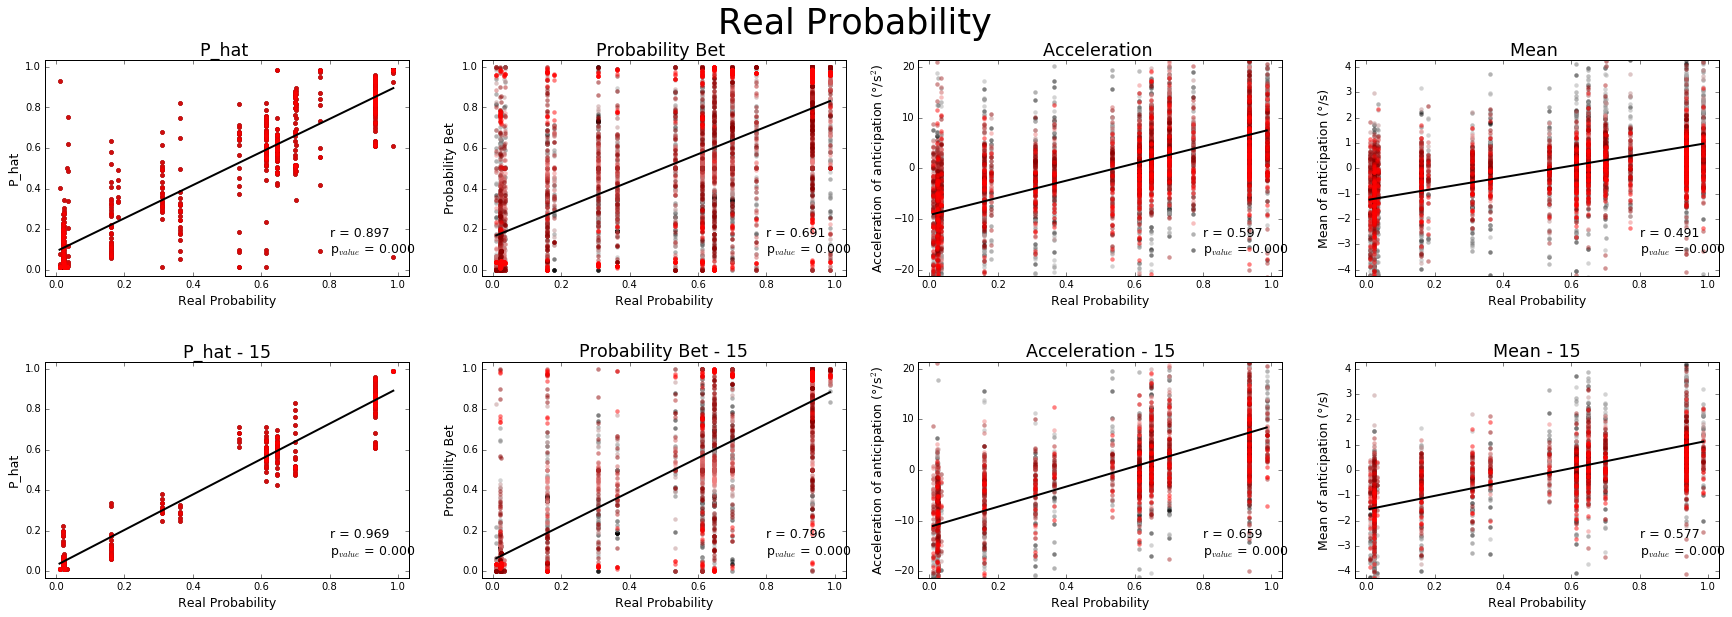

In [11]:
fig, axs = plt.subplots(nb_suppression, 4, figsize=(fig_width*4, (fig_width*nb_suppression)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Real Probability", fontsize=t_titre*2)

for z, comparaison in enumerate(['P_hat', 'Probability Bet', 'Acceleration', 'Mean']) :

    for a, nom in enumerate(liste_suppression) :
        
        proba = full_proba[a]
        proba_s = proba_sujet[a]
        
                
        if z == 0 :
            axs[a][z].set_ylabel('P_hat', fontsize=t_label)
            sujet = p_hat_sujet[a]
            full = full_p_hat[a]
            y_1 = -0.032
            y_2 = 1.032
        
        
        
        if z == 1 :
            axs[a][z].set_ylabel('Probability Bet', fontsize=t_label)
            sujet = results_sujet[a]
            full = full_results[a]
            y_1 = -0.032
            y_2 = 1.032
        
        elif z == 2 :
            axs[a][z].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label)
            sujet = va_sujet[a]
            full = full_va[a]
            y_1 = -21.28
            y_2 = 21.28
        
        elif z == 3 :
            axs[a][z].set_ylabel('Mean of anticipation (°/s)', fontsize=t_label)
            sujet = mean_sujet[a]
            full = full_mean[a]
            y_1 = -4.256#-3.192
            y_2 = 4.256#3.192
            
            # masque les NAN
            proba = np.ma.masked_array(proba, mask=np.isnan(full)).compressed()
            full = np.ma.masked_array(full, mask=np.isnan(full)).compressed()

        
        for x, color in enumerate(colors[:len(proba_sujet[0])]):
            axs[a][z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)

        slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
        x_test = np.linspace(np.min(proba), np.max(proba), 100)
        fitLine = slope * x_test + intercept
        axs[a][z].plot(x_test, fitLine, c='k', linewidth=2)
        axs[a][z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f \np$_{value}$ = %0.3f '%(r_value, p_value), fontsize=t_label)

        axs[a][z].axis([-0.032, 1.032, y_1, y_2])
 
        axs[a][z].set_title("%s %s"%(comparaison, nom), fontsize=t_titre)
        axs[a][z].set_xlabel('Real Probability', fontsize=t_label)

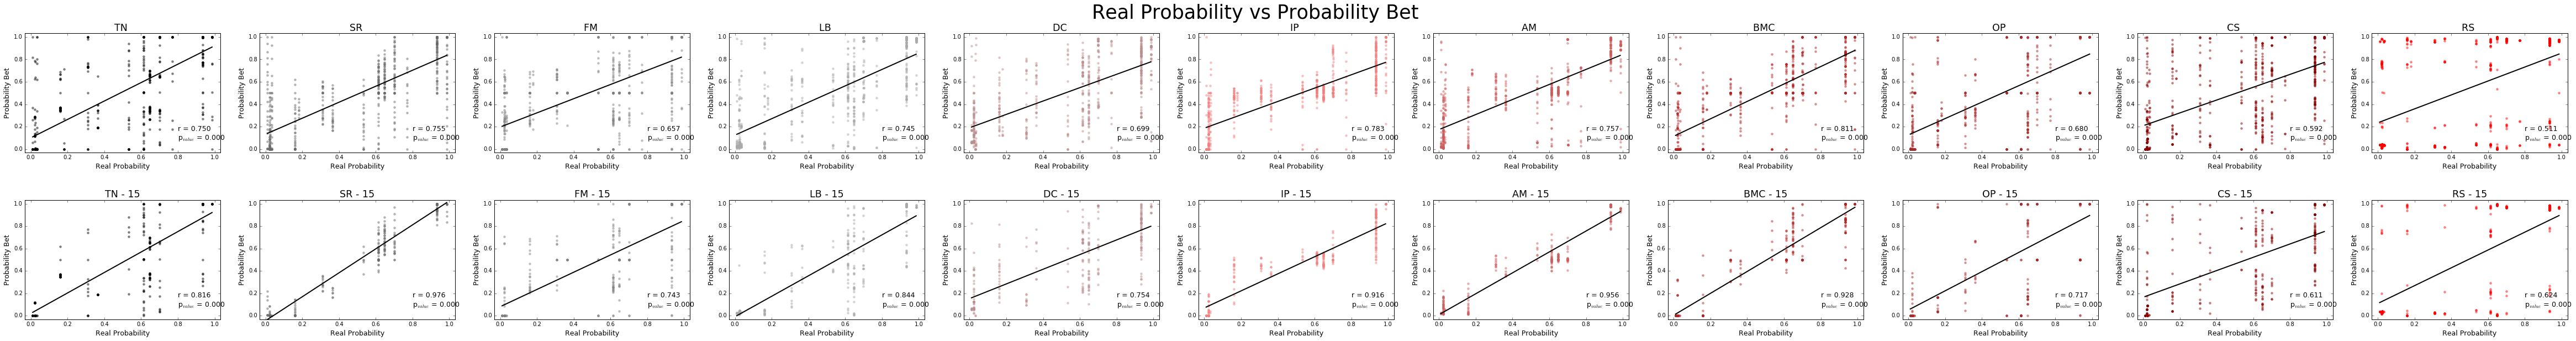

In [12]:
titre = "Real Probability vs Probability Bet"
y_1 = -0.032
y_2 = 1.032
proba = proba_sujet
para = results_sujet
x_label = 'Real Probability'
y_label = 'Probability Bet'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

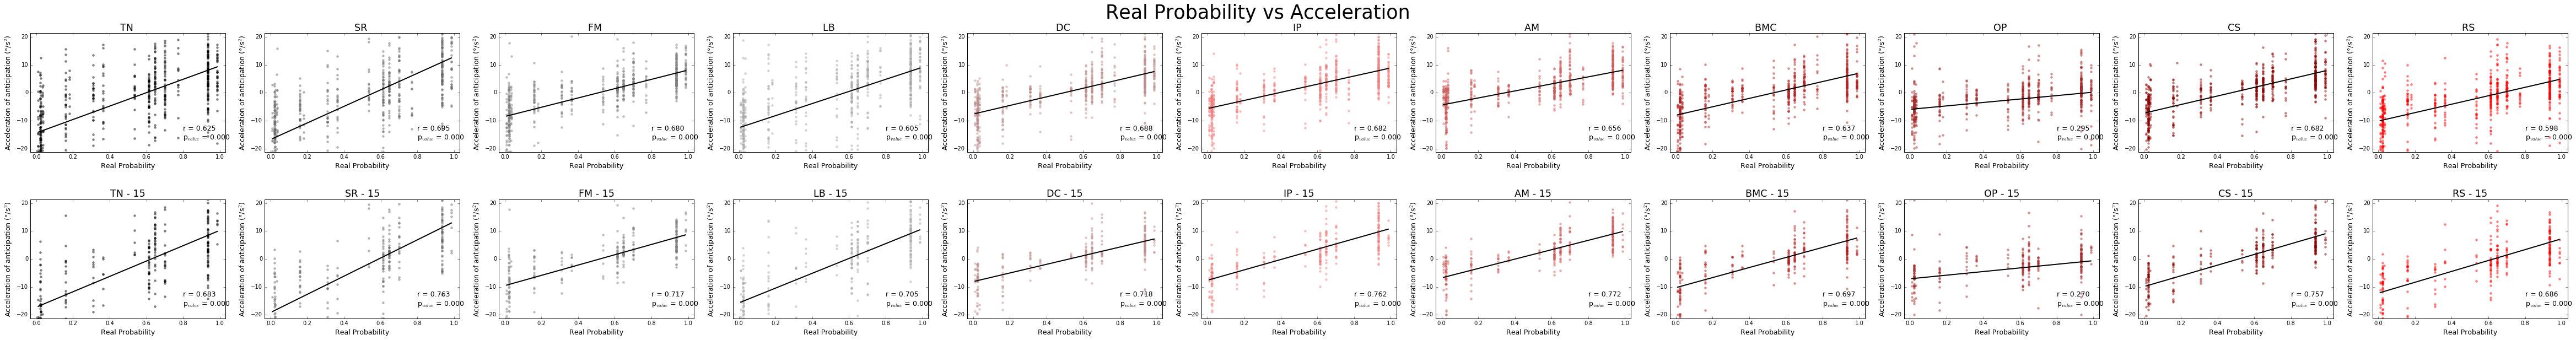

In [13]:
titre = "Real Probability vs Acceleration"
y_1 = -21.28
y_2 = 21.28
proba = proba_sujet
para = va_sujet
x_label = 'Real Probability'
y_label = 'Acceleration of anticipation (°/s$^2$)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

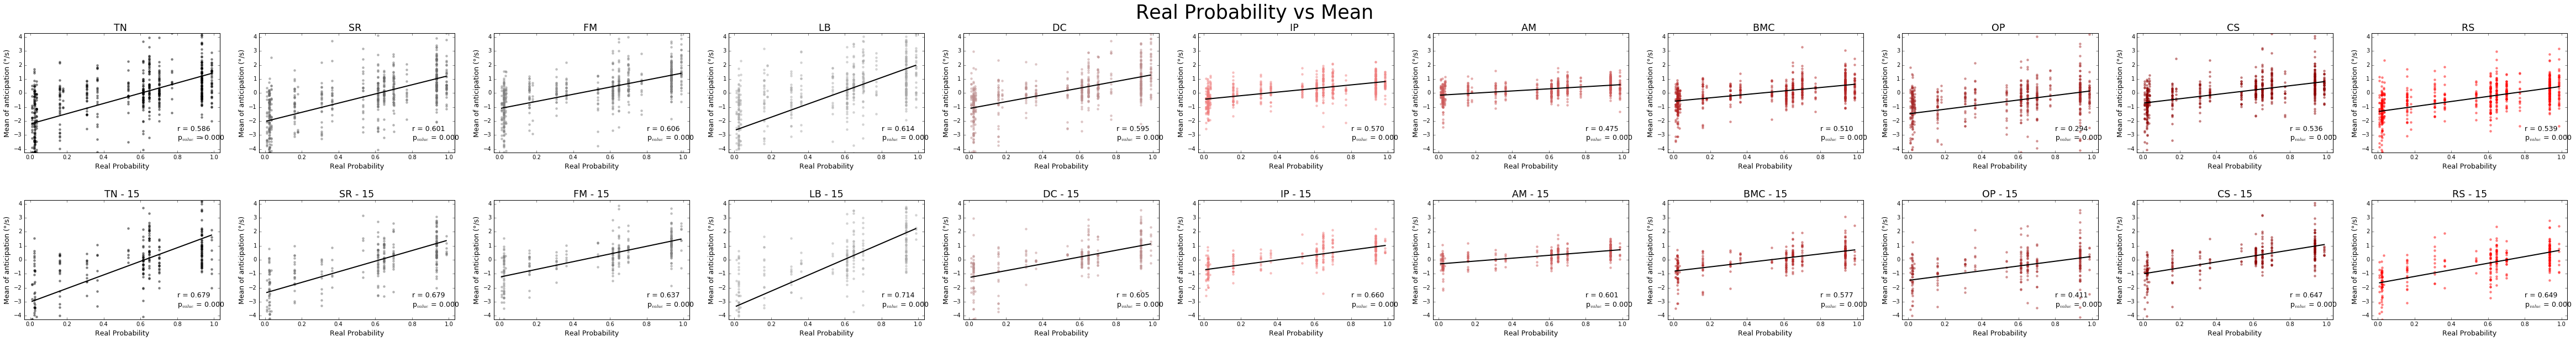

In [14]:
titre = "Real Probability vs Mean"
y_1 = -4.256#-3.192
y_2 = 4.256#3.192
proba = proba_sujet
para = mean_sujet
x_label = 'Real Probability'
y_label = 'Mean of anticipation (°/s)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label, nan=True)

## P_hat

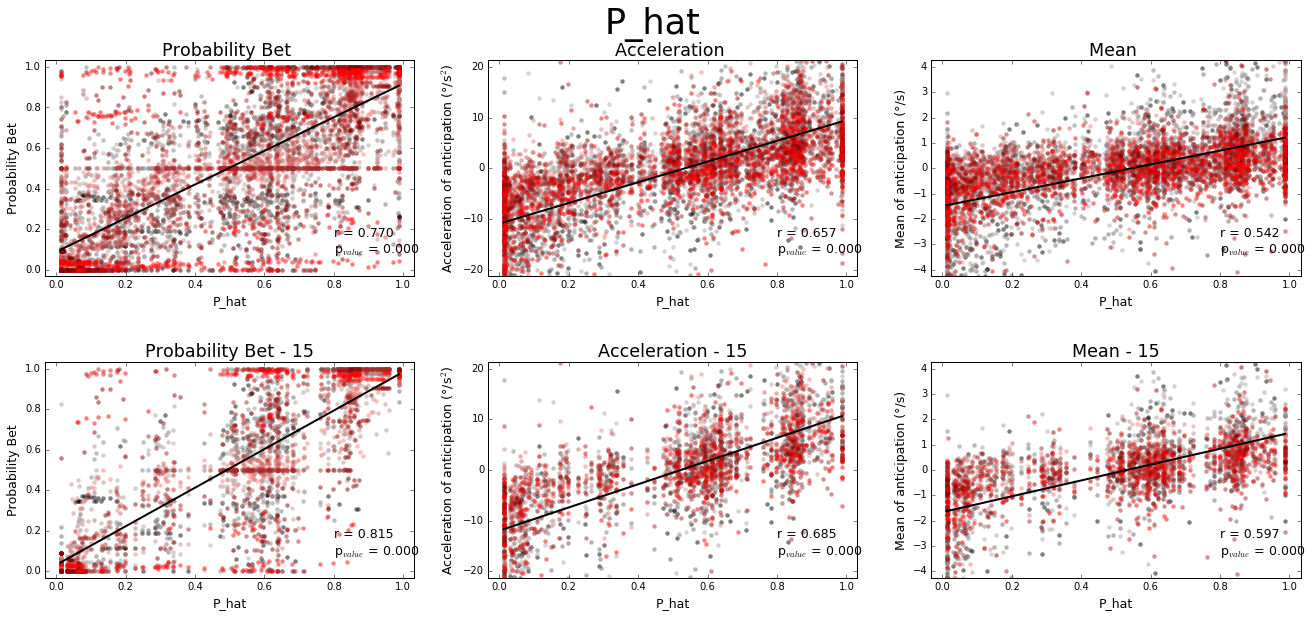

In [15]:
fig, axs = plt.subplots(nb_suppression, 3, figsize=(fig_width*3, (fig_width*nb_suppression)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("P_hat", fontsize=t_titre*2)

for z, comparaison in enumerate(['Probability Bet', 'Acceleration', 'Mean']) :

    for a, nom in enumerate(liste_suppression) :
        
        proba = full_p_hat[a]
        proba_s = p_hat_sujet[a]
        
        if z == 0 :
            axs[a][z].set_ylabel('Probability Bet', fontsize=t_label)
            sujet = results_sujet[a]
            full = full_results[a]
            y_1 = -0.032
            y_2 = 1.032
        
        elif z == 1 :
            axs[a][z].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label)
            sujet = va_sujet[a]
            full = full_va[a]
            y_1 = -21.28
            y_2 = 21.28
        
        elif z == 2 :
            axs[a][z].set_ylabel('Mean of anticipation (°/s)', fontsize=t_label)
            sujet = mean_sujet[a]
            full = full_mean[a]
            y_1 = -4.256#-3.192
            y_2 = 4.256#3.192
            
            # masque les NAN
            proba = np.ma.masked_array(proba, mask=np.isnan(full)).compressed()
            full = np.ma.masked_array(full, mask=np.isnan(full)).compressed()

        
        for x, color in enumerate(colors[:len(proba_sujet[0])]):
            axs[a][z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)

        slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
        x_test = np.linspace(np.min(proba), np.max(proba), 100)
        fitLine = slope * x_test + intercept
        axs[a][z].plot(x_test, fitLine, c='k', linewidth=2)
        axs[a][z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f \np$_{value}$ = %0.3f '%(r_value, p_value), fontsize=t_label)

        axs[a][z].axis([-0.032, 1.032, y_1, y_2])
 
        axs[a][z].set_title("%s %s"%(comparaison, nom), fontsize=t_titre)
        axs[a][z].set_xlabel('P_hat', fontsize=t_label)

TODO: connaissant la probabilité a priori de p_hat, on peut normaliser le poids de chaque point pour calculer le r2

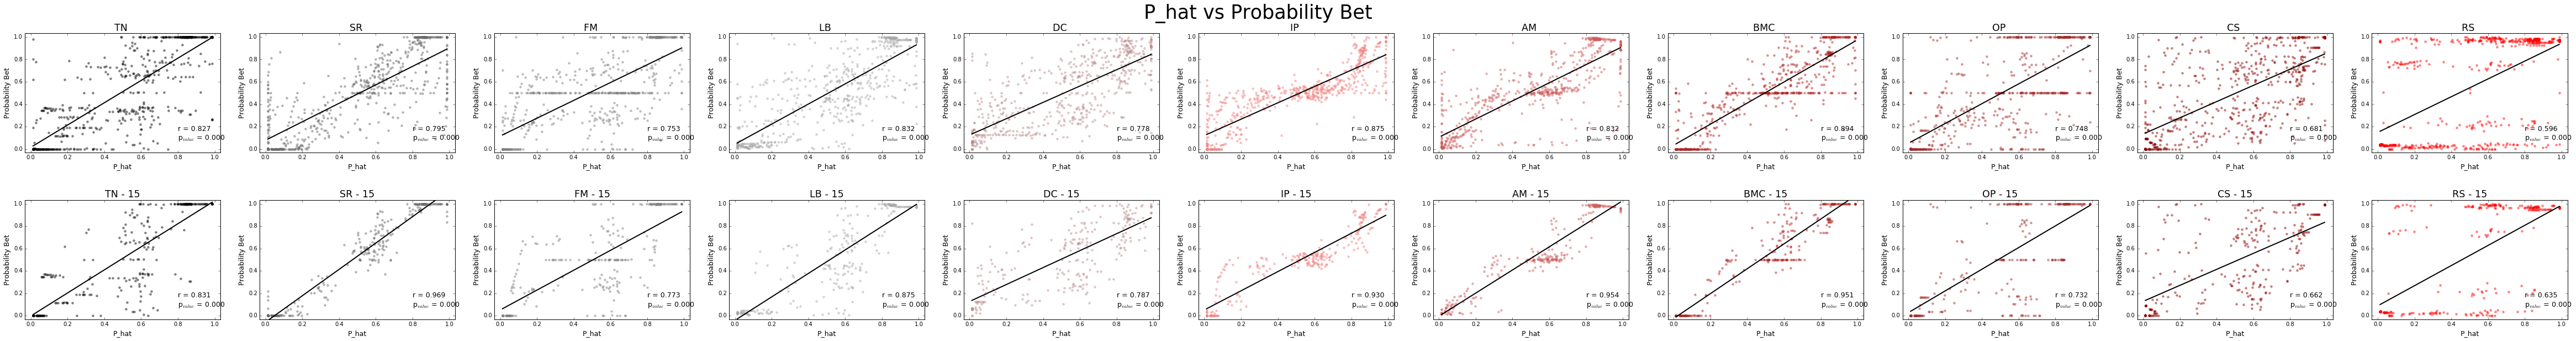

In [16]:
titre = " P_hat vs Probability Bet"
y_1 = -0.032
y_2 = 1.032
proba = p_hat_sujet
para = results_sujet
x_label = 'P_hat'
y_label = 'Probability Bet'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

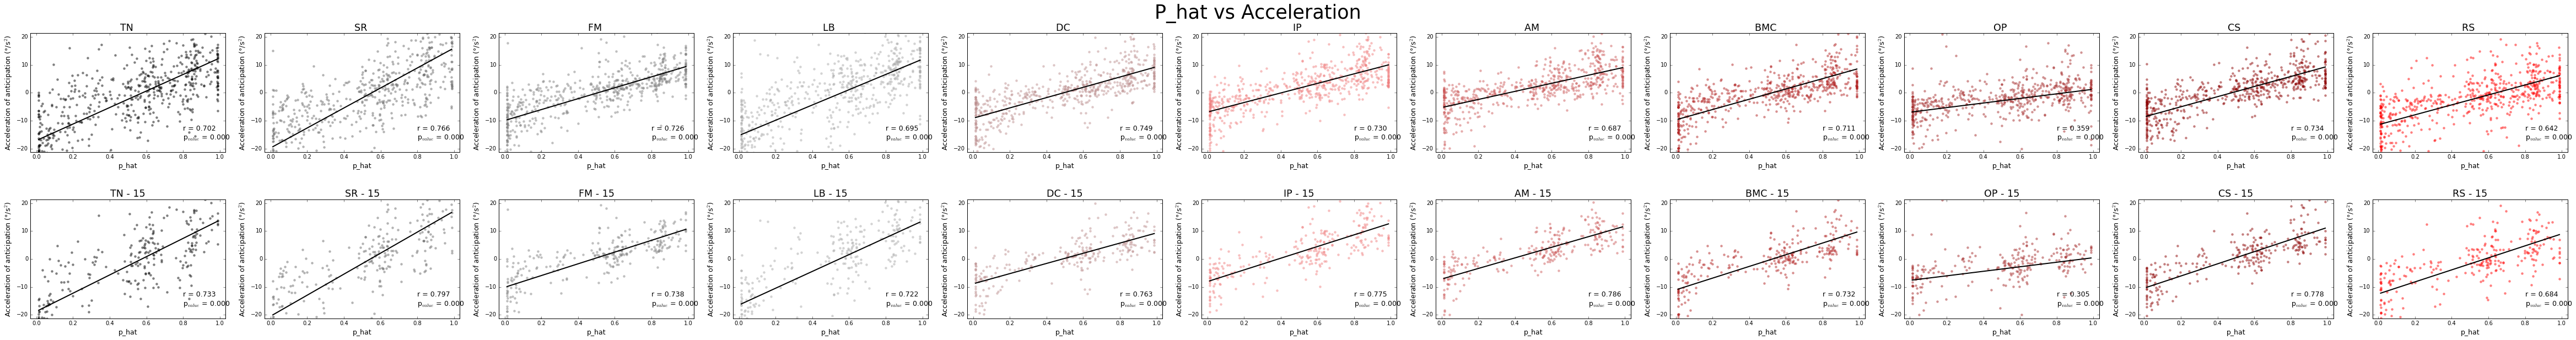

In [17]:
titre = "P_hat vs Acceleration"
y_1 = -21.28
y_2 = 21.28
proba = p_hat_sujet
para = va_sujet
x_label = 'p_hat'
y_label = 'Acceleration of anticipation (°/s$^2$)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

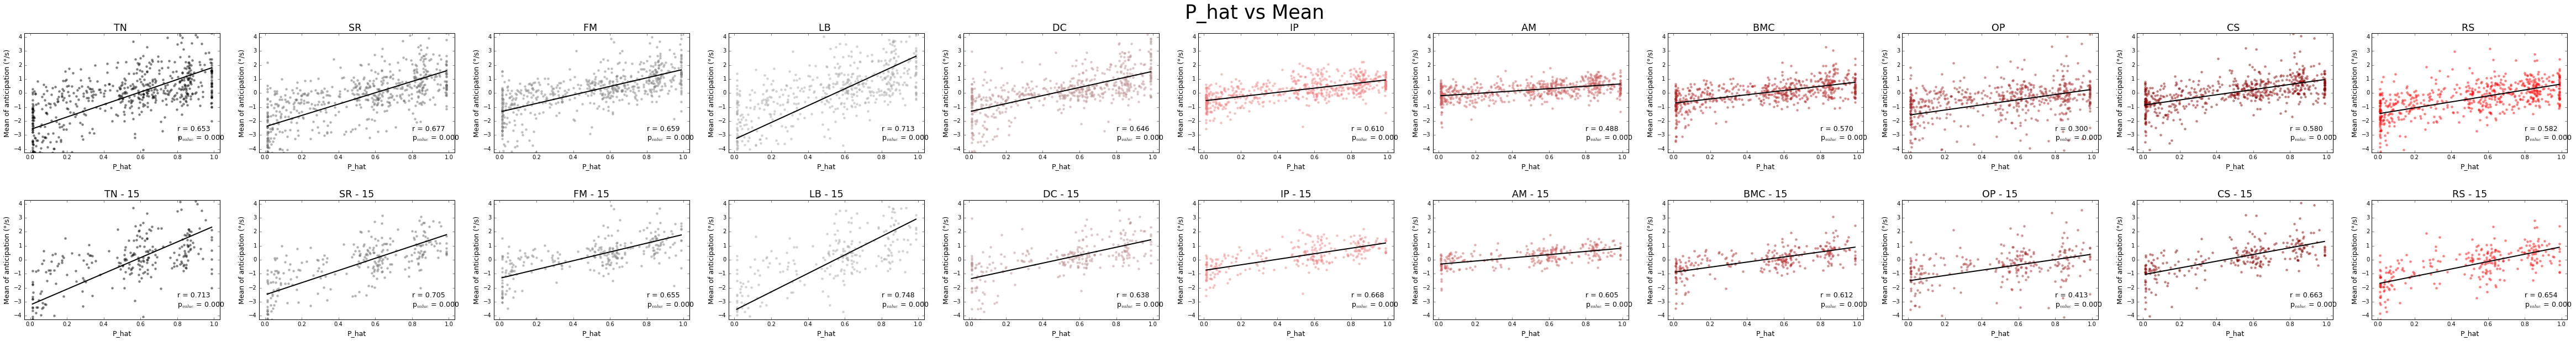

In [18]:
titre = "P_hat vs Mean"
y_1 = -4.256#-3.192
y_2 = 4.256#3.192
proba = p_hat_sujet
para = mean_sujet
x_label = 'P_hat'
y_label = 'Mean of anticipation (°/s)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label, nan=True)

## Probabilité parié

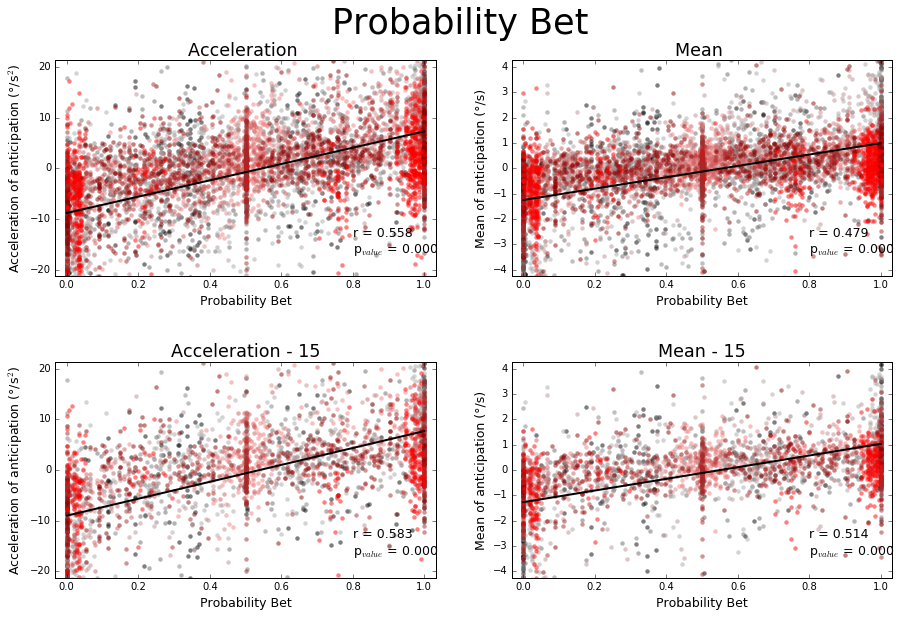

In [19]:
fig, axs = plt.subplots(nb_suppression, 2, figsize=(fig_width*2, (fig_width*nb_suppression)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Probability Bet", fontsize=t_titre*2)

for z, comparaison in enumerate(['Acceleration', 'Mean']):

    for a, nom in enumerate(liste_suppression) :
        
        proba = full_results[a]
        proba_s = results_sujet[a]
        if z == 0 :
            axs[a][z].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label)
            sujet = va_sujet[a]
            full = full_va[a]
            y_1 = -21.28
            y_2 = 21.28
        
        elif z == 1 :
            axs[a][z].set_ylabel('Mean of anticipation (°/s)', fontsize=t_label)
            sujet = mean_sujet[a]
            full = full_mean[a]
            y_1 = -4.256#-3.192
            y_2 = 4.256#3.192
            
            # masque les NAN
            proba = np.ma.masked_array(proba, mask=np.isnan(full)).compressed()
            full = np.ma.masked_array(full, mask=np.isnan(full)).compressed()
        
 
            
        for x, color in enumerate(colors[:nb_sujet]):
            axs[a][z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)
        

        slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
        x_test = np.linspace(np.min(proba), np.max(proba), 100)
        fitLine = slope * x_test + intercept

        axs[a][z].plot(x_test, fitLine, c='k', linewidth=2)
        axs[a][z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f \np$_{value}$ = %0.3f '%(r_value, p_value), fontsize=t_label)

        axs[a][z].axis([-0.032, 1.032, y_1, y_2])
 
        axs[a][z].set_title("%s %s"%(comparaison, nom), fontsize=t_titre)
        axs[a][z].set_xlabel('Probability Bet', fontsize=t_label)

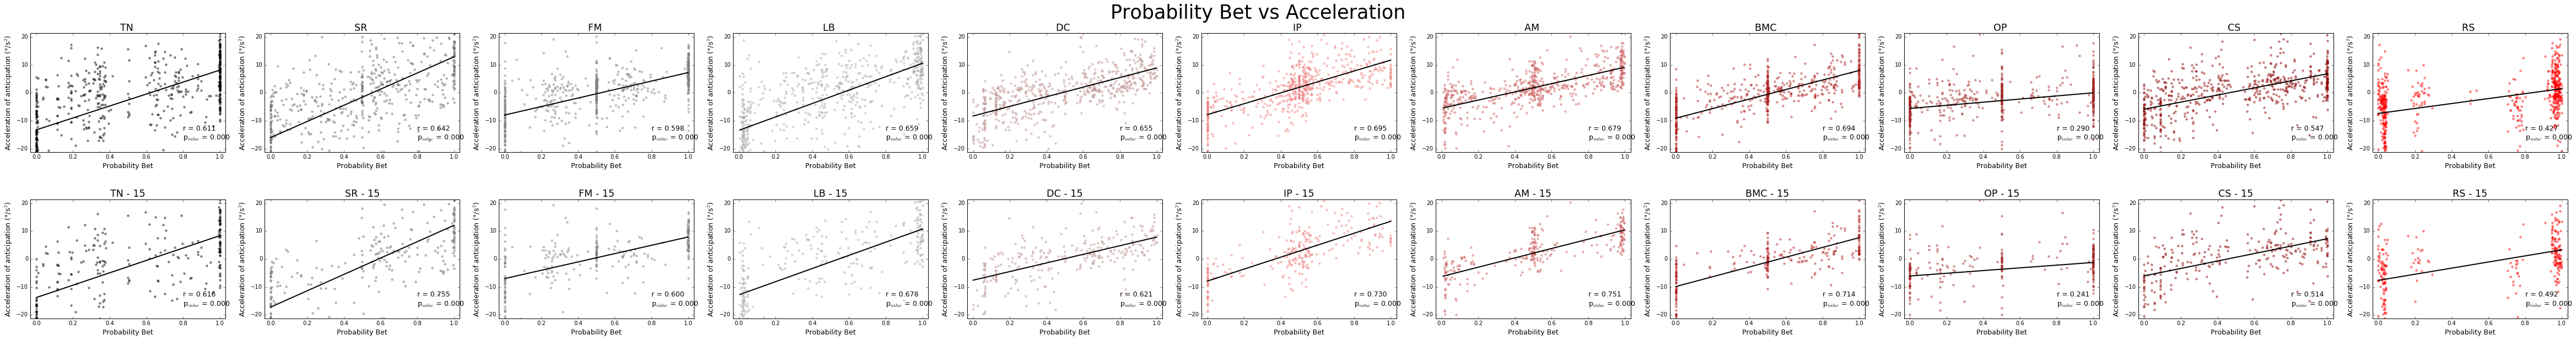

In [20]:
titre = "Probability Bet vs Acceleration"
y_1 = -21.28
y_2 = 21.28
proba = results_sujet
para = va_sujet
x_label = 'Probability Bet'
y_label = 'Acceleration of anticipation (°/s$^2$)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

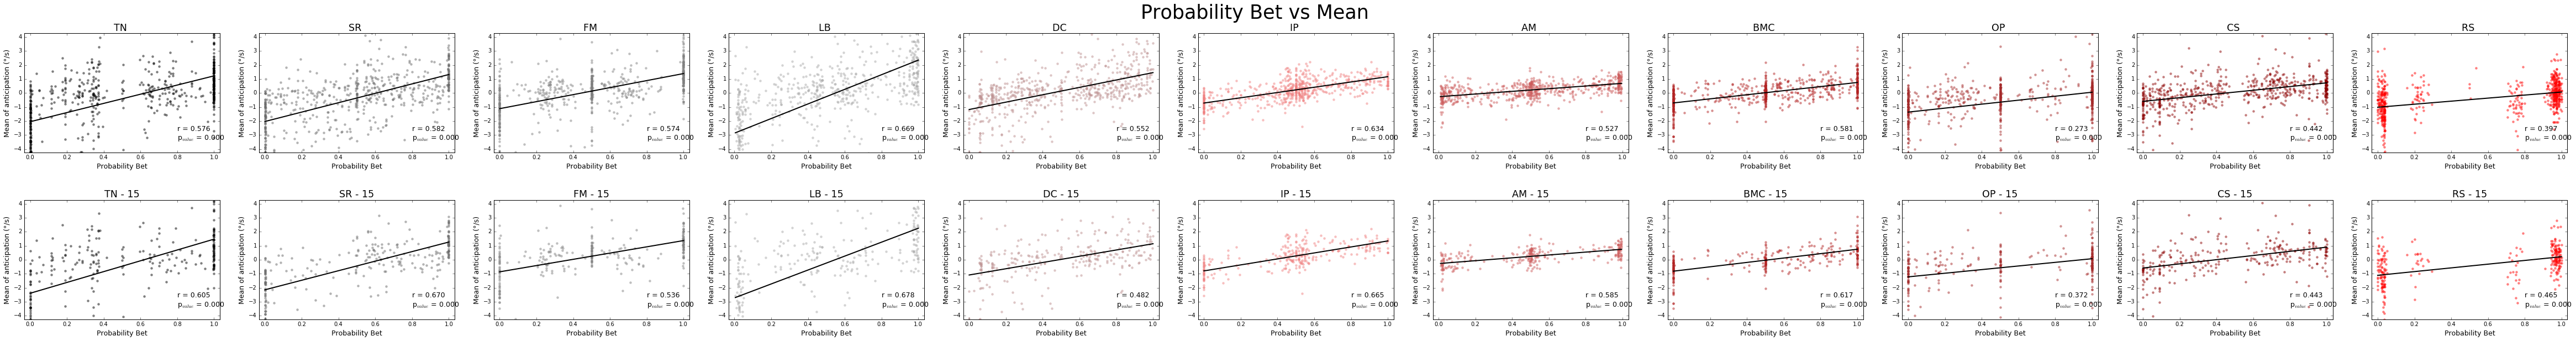

In [21]:
titre = "Probability Bet vs Mean"
y_1 = -4.256#-3.192
y_2 = 4.256#3.192
proba = results_sujet
para = mean_sujet
x_label = 'Probability Bet'
y_label = 'Mean of anticipation (°/s)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label, nan=True)